In [ ]:
# Objective : Implement different sequence lengths to understand their effect on
#             the performance of the transformer model.
# instruction : change the sequence length to 50
#               preprocess the data set with new sequence length
#               train the model and compare the training loss

In [ ]:
! pip install pandas
! pip install scikit-learn

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
# load dataset
data_url ='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WHA_mc9FWSVjCGLSLAp48A/stock-prices.csv'
# load csv -> using Pandas_read function
df = pd.read_csv(data_url)

In [ ]:
# select the any relevant column on dataset
print(df[:2])

# choose 'Close'
data = df[['Close']].values

         Date  Open  High  Low  Close  Volume
0  01-01-2023   100   102   98    101  100000
1  02-01-2023   101   103   99    102  110000


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data)

[[0.        ]
 [0.03448276]
 [0.06896552]
 [0.10344828]
 [0.13793103]
 [0.17241379]
 [0.20689655]
 [0.24137931]
 [0.27586207]
 [0.31034483]
 [0.34482759]
 [0.37931034]
 [0.4137931 ]
 [0.44827586]
 [0.48275862]
 [0.51724138]
 [0.55172414]
 [0.5862069 ]
 [0.62068966]
 [0.65517241]
 [0.68965517]
 [0.72413793]
 [0.75862069]
 [0.79310345]
 [0.82758621]
 [0.86206897]
 [0.89655172]
 [0.93103448]
 [0.96551724]
 [1.        ]]


In [ ]:
# check the number of samples in the data
n_samples = data.shape[0]
print(f"Number of samples in the data: {n_samples}")

Number of samples in the data: 30


In [ ]:
#Ensure we have enough data by setting a reasonable train size
if n_samples < 100:
  print("dataset is very small, using 50% of the data for training")
  train_size = 0.5
  seq_length = 5 # use a shorter sequence length for very small
else:
    train_size = 0.1
    seq_length = 50 # fit the instruction

dataset is very small, using 50% of the data for training


In [ ]:
# reduce dataset suze for quicker runs
X, _, Y, _ = train_test_split(data, data, train_size=train_size, random_state=42)
# train dataset keep, test dataset won't use

In [ ]:
# Preprocess the dataset with adjusted sequence length
def create_dataset(data, time_step=seq_length):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(data, seq_length)

# Check if the generated sequences have valid shapes
if X.size == 0 or Y.size == 0:
    raise ValueError(f"The dataset is too small to create sequences with a length of {seq_length}. Reduce the sequence length or use a larger dataset.")

X = X.reshape(X.shape[0], X.shape[1], 1)
# The data is reshaped for 3D format - used to in LSTM model.

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (24, 5, 1)
Shape of Y: (24,)


In [ ]:
# define a simpler transformer block for faster runs
from tensorflow.keras.layers import Layer
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):  # Set training argument default to False
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.2985


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8947 
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7663 


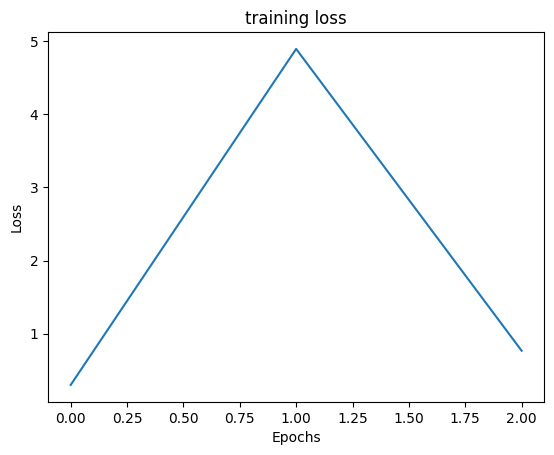

In [ ]:
# build and compile the model
input_shape = (X.shape[1], X.shape[2])
inputs= tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Dense(64)(inputs) # reduced embed_dim for faster runs
transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)
# reduce model complexity
x = transformer_block(x,training = True)
flatten = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error')

# early stopping to stop training when no improvment is seen
early_stopping = EarlyStopping(monitor='loss', patience=2,restore_best_weights=True)

#train the model with reduced epochs and steps
history = model.fit(X, Y, epochs=5, batch_size=32, callbacks=[early_stopping], steps_per_epoch=10)

#plot training
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("training loss")
plt.show()


In [ ]:
# exercise 2 : implement a learning rate scheduler to adjust the learning rate during training
# Instruction : Define a learning rate scheduler that reduces the learning rate by half every 10 epochs
#               train the model with the learning rate scheduler and compare the training loss


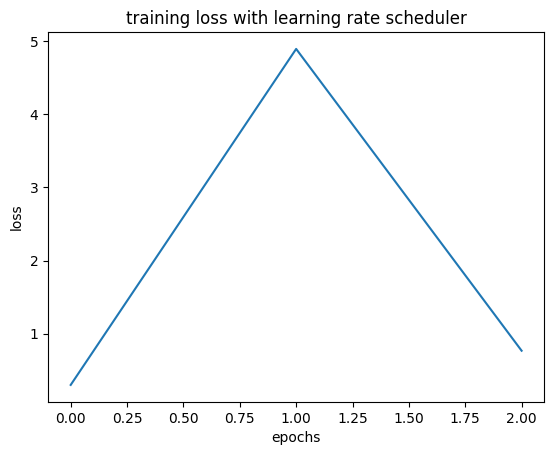

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
import matplotlib.pyplot as plt

def scheduler(epoch, lr):
  if epoch % 10 == 0 and epoch!=0:
    Ir = Ir * 0.5
  return Ir

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


plt.plot(history.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("training loss with learning rate scheduler")
plt.show()

In [ ]:
# exercise 3 : to explore the model's text generation capabilites and generate longer sequences
# instruction : modify the generate_text function to generate 200 tokens instead of 100
#               generate text using the trained model and the modified function


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf

# Define the vectorizer
vectorizer = tf.keras.layers.TextVectorization(output_mode='int', output_sequence_length=5)

# Fit the vectorizer on some example data (e.g., a small corpus)
corpus = ["To be, or not to be", "That is the question"]
vectorizer.adapt(corpus)

# Now, you can use the vectorizer to convert text to integers
def generate_text(model, start_string, num_generate=200):
    # Convert the start string to numbers (vectorize)
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input tensor has the correct shape
    input_eval = tf.convert_to_tensor(input_eval[:, -5:])  # Ensure it has a shape of (1, 5)

    text_generated = []

    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Ensure predictions is a matrix with shape [batch_size, num_classes]
        predictions = tf.squeeze(predictions, 0)  # Remove the batch dimension
        predictions = tf.expand_dims(predictions, 0)  # Add back a batch dimension for categorical

        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -5:]  # Keep only the last 5 tokens to match input shape
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor

        # Add the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    return start_string + ' ' + ' '.join(text_generated)

# Generate longer text
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string)

print(generated_text)

To be, or not to be                                                                                                                                                                                                        
